# Resource project scheduling problems

In this notebook, we explore how to solve a resource constrained project scheduling problem (RCPSP).

The problem is made of $M$ activities that have precedence constraints. That means that if activity $j\in[1,M]$ is a successor of activity $i\in[1,M]$, then activity $i$ must be completed before activity $j$ can be started

On top of these constraints, each project is assigned a set of K renewable resources where each resource $k$ is available in $R_{k}$ units for the entire duration of the project. Each activity may require one or more of these resources to be completed. While scheduling the activities, the daily resource usage for resource $k$ can not exceed $R_{k}$ units.

Each activity $j$ takes $d_{j}$ time units to complete.

The overall goal of the problem is usually to minimize the makespan.

A classic variant of RCPSP is the multimode RCPSP where each task can be executed in several ways (one way=one mode). A typical example is :

Mode n°1 'Fast mode': high resource consumption and fast
Mode n°2 'Slow mode' : low resource consumption but slow

## Prerequisites

Before running this notebook, you need to 
- install discrete-optimization in your jupyter kernel
    ```
    pip install discrete-optimization
    ```

In [1]:
#!pip install discrete_optimization # should take 2 minutes ?

## Imports

In [2]:
import os
os.environ["DO_SKIP_MZN_CHECK"] = "1"
import logging
import random
import matplotlib.pyplot as plt
import nest_asyncio
import networkx as nx
import numpy as np
from discrete_optimization.datasets import fetch_data_from_psplib
# Main module for RCPSP Model
from discrete_optimization.rcpsp.rcpsp_model import RCPSPSolution, RCPSPModel
from discrete_optimization.rcpsp.rcpsp_parser import get_data_available, parse_file
from discrete_optimization.rcpsp.rcpsp_utils import (
    Graph,
    compute_graph_rcpsp,
    plot_ressource_view,
    plot_task_gantt,
)
# patch asyncio so that applications using async functions can run in jupyter
nest_asyncio.apply()
# set logging level
logging.basicConfig(level=logging.INFO)

### Download datasets

If not yet available, we import the datasets from [psplib](https://www.om-db.wi.tum.de/psplib/data.html).

In [3]:
needed_datasets = ["j301_1.sm"]
download_needed = False
try:
    files_available_paths = get_data_available()
    for dataset in needed_datasets:
        if len([f for f in files_available_paths if dataset in f]) == 0:
            download_needed = True
            break
except:
    download_needed = True

if download_needed:
    fetch_data_from_psplib()

## Loading the problems definition

In [4]:
files_available = get_data_available()

Now we can load some RCPSP problem from provided examples

In [5]:
filepath = [f for f in get_data_available() if "j301_1.sm" in f][0]
with open(filepath, "rt") as f:
    print(f.read())

************************************************************************
file with basedata            : j30_17.bas
initial value random generator: 28123
************************************************************************
projects                      :  1
jobs (incl. supersource/sink ):  32
horizon                       :  158
RESOURCES
  - renewable                 :  4   R
  - nonrenewable              :  0   N
  - doubly constrained        :  0   D
************************************************************************
PROJECT INFORMATION:
pronr.  #jobs rel.date duedate tardcost  MPM-Time
    1     30      0       38       26       38
************************************************************************
PRECEDENCE RELATIONS:
jobnr.    #modes  #successors   successors
   1        1          3           2   3   4
   2        1          3           6  11  15
   3        1          3           7   8  13
   4        1          3           5   9  10
   5        1          1     

There are 32 jobs, including the source task (1) and the sink task (32). 

- The first part of the file describe the precedence constraints : 
  > Task $1$ should finish before task $2$, $3$, $4$ start.
  
- The second part of the file details the duration and resource usage per task : 
  > Task $3$ lasts 4 units of times and requires 10 units of $R_1$

### Parsing file
We parse the file to get a RCPSP model object in discrete-optimization library.

In [6]:
filepath = [f for f in get_data_available() if "j301_1.sm" in f][0]
rcpsp_model = parse_file(filepath)
print(type(rcpsp_model))
print(rcpsp_model)
print("Nb jobs : ", rcpsp_model.n_jobs)
print("Precedences : ", rcpsp_model.successors)
print("Resources Availability : ", rcpsp_model.resources)

<class 'discrete_optimization.rcpsp.rcpsp_model.RCPSPModel'>
I'm a RCPSP model with 32 tasks.. and ressources =['R1', 'R2', 'R3', 'R4']
Nb jobs :  32
Precedences :  {1: [2, 3, 4], 2: [6, 11, 15], 3: [7, 8, 13], 4: [5, 9, 10], 5: [20], 6: [30], 7: [27], 8: [12, 19, 27], 9: [14], 10: [16, 25], 11: [20, 26], 12: [14], 13: [17, 18], 14: [17], 15: [25], 16: [21, 22], 17: [22], 18: [20, 22], 19: [24, 29], 20: [23, 25], 21: [28], 22: [23], 23: [24], 24: [30], 25: [30], 26: [31], 27: [28], 28: [31], 29: [32], 30: [32], 31: [32], 32: []}
Resources Availability :  {'R1': 12, 'R2': 13, 'R3': 4, 'R4': 12}


### Precedence graph
We can have a visual version of the precedence graph :

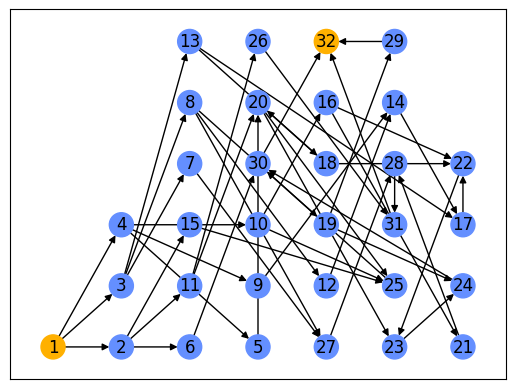

In [7]:
# compute graph
graph: Graph = compute_graph_rcpsp(rcpsp_model)
graph_nx = graph.to_networkx()
# compute positions
dfs = nx.dfs_tree(G=graph_nx, source=1, depth_limit=10)
shortest_path_length = nx.shortest_path_length(dfs, 1)
length_to_nodes = {}
position = {}
for node in sorted(shortest_path_length, key=lambda x: shortest_path_length[x]):
    length = shortest_path_length[node]
    while not (length not in length_to_nodes or len(length_to_nodes[length]) <= 5):
        length += 1
    if length not in length_to_nodes:
        length_to_nodes[length] = []
    length_to_nodes[length] += [node]
    position[node] = (length, len(length_to_nodes[length]))

# different color for source and sink task
sink_source_color = "#FFB000"
normal_task_color = "#648FFF"
node_color = len(graph_nx) * [normal_task_color]
node_color[0] = sink_source_color
node_color[-1] = sink_source_color

# plot
nx.draw_networkx(graph_nx, pos=position, node_color=node_color)
plt.show()

# Compute critical path

The critical path in project management is the longest path in the problem that can't be compressed, therefore it is a lower bound on the optimal makespan that is reachable. It represents a path in the precedence graph.
To compute the critical, one can compute a largest path in the precedence constraints. 

In [8]:
import networkx as nx
for edge in graph_nx.edges():
    graph_nx[edge[0]][edge[1]]["min_duration"] = min([rcpsp_model.mode_details[edge[1]][mode]["duration"]
                                                      for mode in rcpsp_model.mode_details[edge[1]]])
path = nx.dag_longest_path(G=graph_nx, weight='min_duration', 
                           default_weight=1, topo_order=None)
edges = [(n1, n2) for n1, n2 in zip(path[:-1], path[1:])]
duration = sum(graph_nx[n[0]][n[1]]["min_duration"] for n in edges)
print("Duration of critical path : ", duration)

Duration of critical path :  38


### Plot the critical path : 

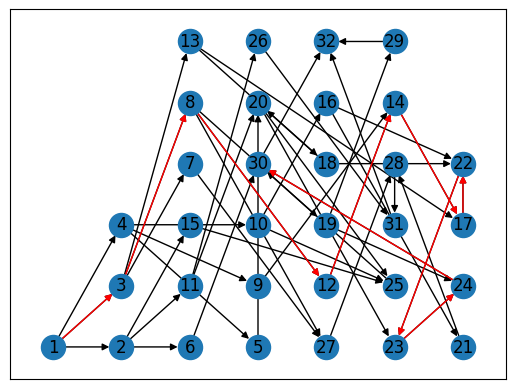

In [9]:
fig, ax = plt.subplots(1)
nx.draw_networkx(graph_nx, pos=position, ax=ax)
nx.draw_networkx_edges(graph_nx, pos=position, edgelist=edges, edge_color="r", ax=ax)

## Other procedure to compute critical path or minimum project duration

The critical path can be computed by a graph procedure described in https://www.youtube.com/watch?v=4oDLMs11Exs. It is a quite simple algorithm, doing forward and backward graph exploration. In the end it provides earliest start date, earliest finish date, and their counterpart (for a optimal schedule ignoring resource constraints) : latest start date, latest finish date.

In [11]:
from discrete_optimization.rcpsp.solver.cpm import CPM
solver = CPM(rcpsp_model)
critical_path = solver.run_classic_cpm()
edges = [(pi, pi1) for pi, pi1 in zip(critical_path[:-1], critical_path[1:])]
print(solver.map_node[rcpsp_model.sink_task])

{'_ESD': 38, '_EFD': 38, '_LSD': 38, '_LFD': 38}


The critical path can be identified as nodes where all the values are equals.

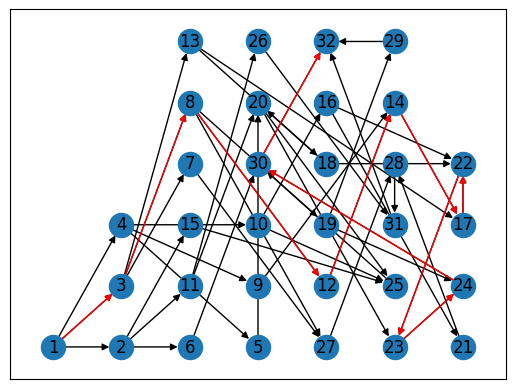

In [12]:
fig, ax = plt.subplots(1)
nx.draw_networkx(graph_nx, pos=position, ax=ax)
nx.draw_networkx_edges(graph_nx, pos=position, edgelist=edges, edge_color="r", ax=ax)

For ressource constrained scheduling problems, this forward/backward pass is not sufficient to compute a schedule, because the ressource capacity constraints are not taken into account. However the *ESD*, *LSD*, *EFD*, *LFD* values can be used in various heuristics to schedule tasks by priority.

## Plotting a solution

In [13]:
some_solution = rcpsp_model.get_dummy_solution()

/Users/poveda_g/miniconda3/envs/aibt_env/lib/python3.9/site-packages/numba/cpython/hashing.py:482: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


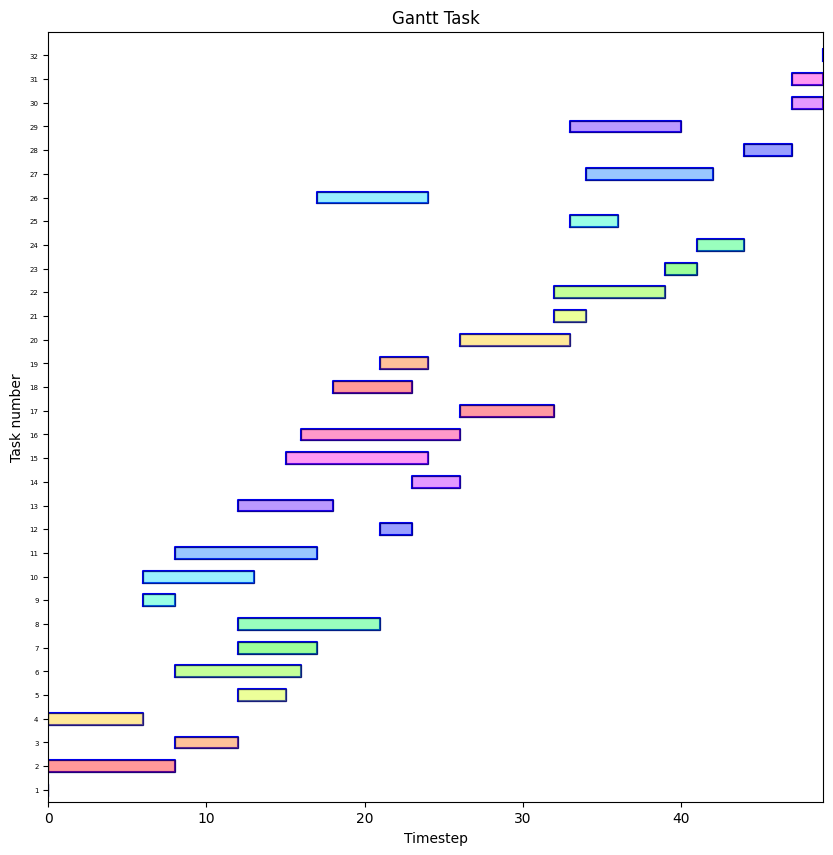

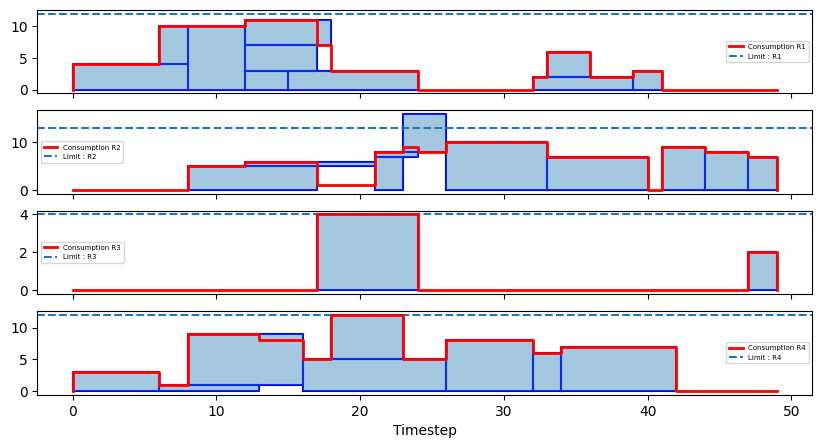

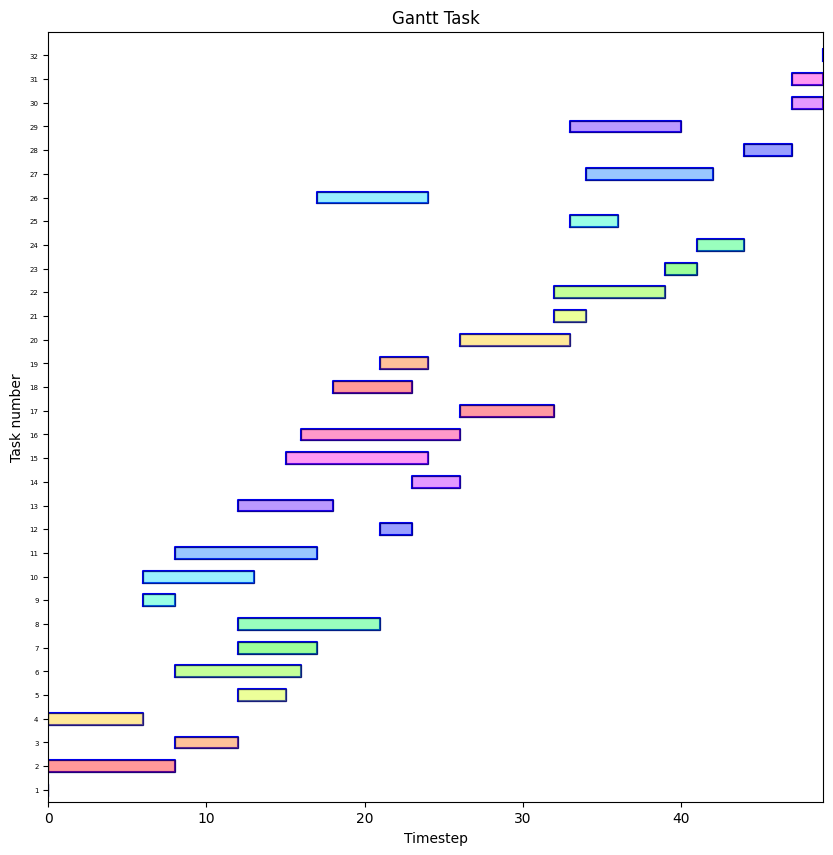

In [14]:
from discrete_optimization.rcpsp.rcpsp_utils import plot_ressource_view, plot_task_gantt
plot_ressource_view(rcpsp_model, some_solution)
plot_task_gantt(rcpsp_model, some_solution)

## SGS : Serial Generation Scheme


![image.png](images/sgs.png)

SGS algorithms is an procedure that aims at building *feasible* schedule from a permutation of task. The task are inserted in the priority order they are in the permutation list, as soon as possible.

## Exercise : 
code the SGS algorithm based on the previous algorithm !

In [15]:
import numpy as np
def sgs_algorithm(rcpsp_model: RCPSPModel, 
                  permutation_of_task: List[Hashable], predecessors=None):
    # Compute predecessors for each task. 
    if predecessors is None:
        predecessors = {k: set() for k in rcpsp_model.tasks_list}
        for k in rcpsp_model.successors:
            succ = rcpsp_model.successors[k]
            for s in succ:
                predecessors[s].add(k)
    # duration of the tasks.
    duration_task = {k: rcpsp_model.mode_details[k][1]["duration"] for k in rcpsp_model.mode_details}

    # Schedule to fill..
    schedule = {k: {"start_time": None,
                    "end_time": None}
                for k in rcpsp_model.tasks_list}
    
    
    resources_availability = {r: rcpsp_model.get_resource_availability_array(r) 
                              for r in rcpsp_model.resources_list}
    while True:
        # Select task to be scheduled at this round...
        # etc
        
        schedule[??]["start_time"] = ?
        schedule[??]["end_time"] = ?
    return schedule    

SyntaxError: invalid syntax (3900278024.py, line 26)

If you are blocked, you can retrieve one corrected version of the SGS by decommenting the following cell : 

In [21]:
# %load correction/nb1_correction.py
import numpy as np
from typing import List, Hashable
def sgs_algorithm(rcpsp_model: RCPSPModel, 
                  permutation_of_task: List[Hashable], predecessors=None):
    # Compute predecessors for each task. 
    if predecessors is None:
        predecessors = {k: set() for k in rcpsp_model.tasks_list}
        for k in rcpsp_model.successors:
            succ = rcpsp_model.successors[k]
            for s in succ:
                predecessors[s].add(k)
    # Store partial schedule
    schedule = {k: {"start_time": None,
                    "end_time": None}
                for k in rcpsp_model.tasks_list}
    # Duration of task
    duration_task = {k: rcpsp_model.mode_details[k][1]["duration"] for k in rcpsp_model.mode_details}
    # object to keep track of resource availability.
    resources_availability = {r: np.array(rcpsp_model.get_resource_availability_array(r))
                              for r in rcpsp_model.resources_list}
    
    done = set()
    minimum_time = {t: 0 for t in rcpsp_model.tasks_list}
    while True:
        # Select task to be scheduled at this round...
        # etc
        next_task = next(x for x in permutation_of_task 
                         if all(p in done for p in predecessors[x]) 
                         and x not in done)
        
        if duration_task[next_task] == 0:
            time_to_schedule_task = minimum_time[next_task]
        else:
            time_to_schedule_task = next(t for t in range(minimum_time[next_task], rcpsp_model.horizon)
                                         if 
                                         all(min(resources_availability[r][t:t+duration_task[next_task]])>=
                                             rcpsp_model.mode_details[next_task][1][r]
                                             for r in resources_availability))
        schedule[next_task]["start_time"] = time_to_schedule_task
        schedule[next_task]["end_time"] = time_to_schedule_task+duration_task[next_task]
        for r in resources_availability:
            need = rcpsp_model.mode_details[next_task][1][r]
            if r in rcpsp_model.non_renewable_resources:
                resources_availability[r][schedule[next_task]["start_time"]:]-=need
            else:
                resources_availability[r][schedule[next_task]["start_time"]:schedule[next_task]["end_time"]]-=need
        for s in rcpsp_model.successors[next_task]:
            minimum_time[s] = max(minimum_time[s], schedule[next_task]["end_time"])
        done.add(next_task) 
        if all(x in done for x in schedule):
            break
    return schedule  





## Testing the sgs : 
From the sgs output, it is quite easy to rebuild a RCPSPSolution object and check if it returns a feasible schedule, by calling the ".satisfy()" function.

In [22]:
tasks_list_permutation = list(rcpsp_model.tasks_list)
import random
random.shuffle(tasks_list_permutation)
schedule = sgs_algorithm(rcpsp_model, tasks_list_permutation)
print(schedule)
solution = RCPSPSolution(problem=rcpsp_model, rcpsp_schedule=schedule)
print(rcpsp_model.satisfy(solution))

{1: {'start_time': 0, 'end_time': 0}, 2: {'start_time': 4, 'end_time': 12}, 3: {'start_time': 0, 'end_time': 4}, 4: {'start_time': 0, 'end_time': 6}, 5: {'start_time': 6, 'end_time': 9}, 6: {'start_time': 12, 'end_time': 20}, 7: {'start_time': 12, 'end_time': 17}, 8: {'start_time': 4, 'end_time': 13}, 9: {'start_time': 10, 'end_time': 12}, 10: {'start_time': 6, 'end_time': 13}, 11: {'start_time': 16, 'end_time': 25}, 12: {'start_time': 13, 'end_time': 15}, 13: {'start_time': 4, 'end_time': 10}, 14: {'start_time': 15, 'end_time': 18}, 15: {'start_time': 12, 'end_time': 21}, 16: {'start_time': 26, 'end_time': 36}, 17: {'start_time': 20, 'end_time': 26}, 18: {'start_time': 26, 'end_time': 31}, 19: {'start_time': 13, 'end_time': 16}, 20: {'start_time': 31, 'end_time': 38}, 21: {'start_time': 39, 'end_time': 41}, 22: {'start_time': 36, 'end_time': 43}, 23: {'start_time': 43, 'end_time': 45}, 24: {'start_time': 45, 'end_time': 48}, 25: {'start_time': 38, 'end_time': 41}, 26: {'start_time': 2

Evaluate : 

In [23]:
rcpsp_model.evaluate(solution)

{'makespan': 50.0, 'mean_resource_reserve': 0.0, 'constraint_penalty': 0.0}

### Build a permutation based on critical path computation output :
SGS can be seen as a priority based greedy algorithm, the more the task id is on the left side of the permutation, the more it has chance to be scheduled faster. 
We can therefore build heuristic ordering of the task and run SGS on it. One idea it to reuse output of the CPM algorithm to schedule first the task that have the lowest earliest finish date for example, but you can imagine other rules : 

In [24]:
# list sorted by EFD ?
perm_efd = sorted(rcpsp_model.tasks_list, 
                  key=lambda x: solver.map_node[x]._EFD)
sol_efd = sgs_algorithm(rcpsp_model, perm_efd)
solution_efd = RCPSPSolution(problem=rcpsp_model, rcpsp_schedule=sol_efd)
print("Available fields in CPM output : ", solver.map_node[1].__dict__.keys())

perm_esd = sorted(rcpsp_model.tasks_list, 
                  key=lambda x: solver.map_node[x]._ESD)
sol_esd = sgs_algorithm(rcpsp_model, perm_esd)
solution_esd = RCPSPSolution(problem=rcpsp_model, rcpsp_schedule=sol_esd)

# Try different methods ?
# What would be your best results ?
print("EFD ", rcpsp_model.evaluate(solution_efd))
print("ESD ", rcpsp_model.evaluate(solution_esd))

Available fields in CPM output :  dict_keys(['_ESD', '_EFD', '_LSD', '_LFD'])
EFD  {'makespan': 60.0, 'mean_resource_reserve': 0.0, 'constraint_penalty': 0.0}
ESD  {'makespan': 51.0, 'mean_resource_reserve': 0.0, 'constraint_penalty': 0.0}


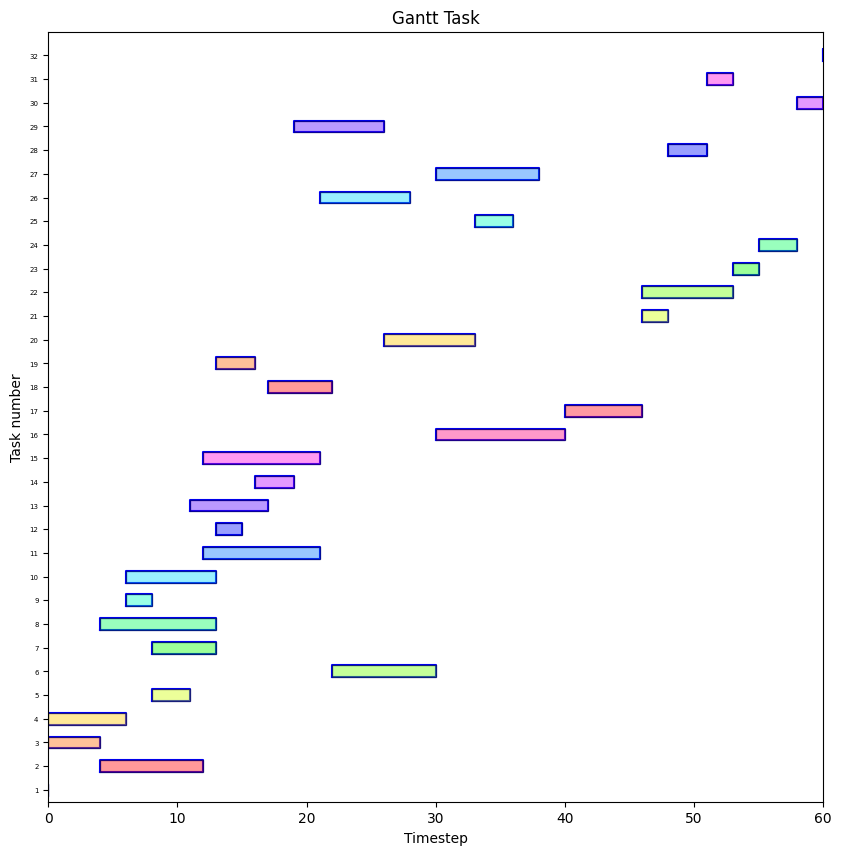

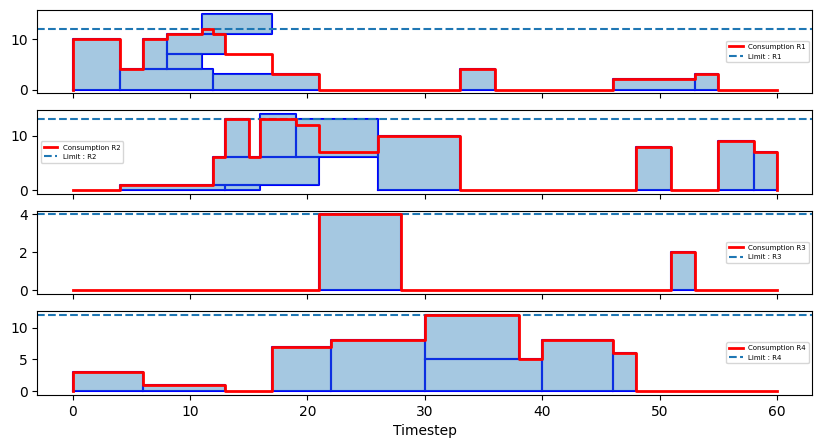

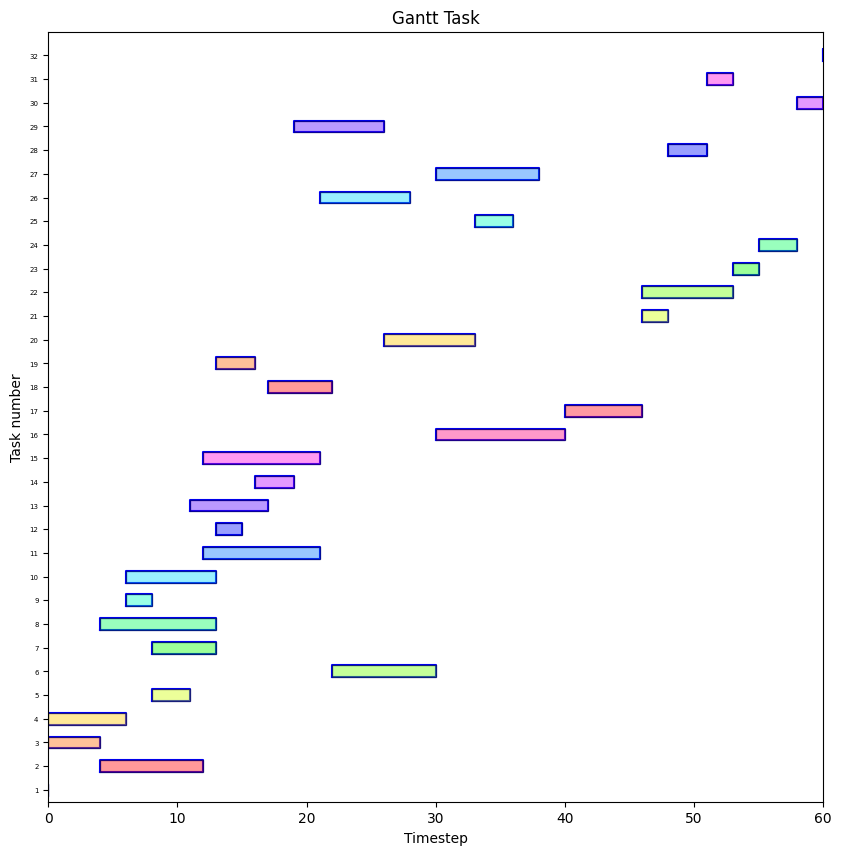

In [25]:
plot_ressource_view(rcpsp_model, solution_efd)
plot_task_gantt(rcpsp_model, solution_efd)

Can you find other priority rule to get better results, or use a random search on ordering to get better solutions ?

## [OPTIONAL] Bonus for those interested 
Going through this [Notebook](https://github.com/airbus/discrete-optimization/blob/master/notebooks/RCPSP%20tutorials/RCPSP-3%20Local%20search.ipynb), is using the "vector" representation of the schedule and run metaheuristics to compute better solutions.
Algorithms used are https://en.wikipedia.org/wiki/Simulated_annealing,
https://en.wikipedia.org/wiki/Hill_climbing